In [7]:
#Fine-Tuning CaPE

In [8]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from itertools import product

In [9]:
query_df = pd.read_csv('Test_Data/query_dataset.csv')
ref_df   = pd.read_csv('Test_Data/reference_dataset.csv')
all_wavs_str = query_df.columns[:-1]
all_wavs_numeric = pd.to_numeric(all_wavs_str)

wavs_to_keep = all_wavs_str[all_wavs_numeric < 1700].tolist()


final_cols_to_keep = wavs_to_keep + ['Species']


query_df = query_df[final_cols_to_keep]
ref_df   = ref_df[final_cols_to_keep]


wavs_str = query_df.columns[:-1]


wavs = wavs_str.astype(float)


In [10]:
def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(intensities):
    out = np.zeros_like(intensities)
    for i, spec in enumerate(intensities):
        bkg = baseline_als(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr/nrm if nrm!=0 else corr
    return out

In [11]:
Q_proc = preprocess(query_df[wavs_str].values.astype(float))
R_proc = preprocess(ref_df[wavs_str].values.astype(float))

dfQ = pd.DataFrame(Q_proc, columns=wavs_str)
dfQ['Species'] = query_df['Species']
dfR = pd.DataFrame(R_proc, columns=wavs_str)
dfR['Species'] = ref_df['Species']

In [12]:
K_vals    = [3]
N_vals    = [15]
W_vals    = [36]
height_vals = [0.02]
prominence_vals = [0.02]

results = []

In [ ]:
for version in ['count', 'intensity']:
    for K_smooth, N_peak, w_max, height, prominence in product(K_vals, N_vals, W_vals, height_vals, prominence_vals):
        # define smoothing
        def smooth_spectrum(spec):
            return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')
        
        # define CaPE
        if version == 'count':
            def CaPE(refs):
                sm = np.array([smooth_spectrum(s) for s in refs])
                counts = np.zeros(sm.shape[1], int)
                for s in sm:
                    pks, _ = find_peaks(s, height=height, prominence=prominence)
                    counts[pks] += 1
                return sorted(np.argsort(counts)[-N_peak:])
        else:
            def CaPE(refs):
                sm = np.array([smooth_spectrum(s) for s in refs])
                intens = np.zeros(sm.shape[1])
                for s in sm:
                    pks, _ = find_peaks(s, height=height, prominence=prominence)
                    intens[pks] += s[pks]
                return sorted(np.argsort(intens)[-N_peak:])
        
        # feature extraction
        def extract_vec(spec, cp_idxs):
            hw = w_max // 2
            vals = [spec[max(0,i-hw):min(len(spec),i+hw+1)].max() for i in cp_idxs]
            return minmax_scale(vals)
        
        # build CPs and compressed references
        CPs = {}
        Ref_comp = {}
        for chem, grp in dfR.groupby('Species'):
            cp = CaPE(grp[wavs_str].values)
            CPs[chem] = cp
            Ref_comp[chem] = np.array([extract_vec(s, cp) for s in grp[wavs_str].values])
        
        # identification
        def CaPSim(qv, rvs): return (rvs @ qv).mean()
        def identify(spec):
            scores = {chem: CaPSim(extract_vec(spec, CPs[chem]), Ref_comp[chem])
                      for chem in CPs}
            sorted_chems = sorted(scores, key=scores.get, reverse=True)
            return sorted_chems
        
        # evaluate top-1 and top-2
        top1 = top2 = 0
        for _, row in dfQ.iterrows():
            preds = identify(row[wavs_str].values)
            true = row['Species']
            if true == preds[0]: top1 += 1
            if true in preds[:2]: top2 += 1
        total = len(dfQ)
        results.append({
            'version': version, 'K_smooth': K_smooth,
            'N_peak': N_peak, 'w_max': w_max, 'height': height, 'prominence': prominence,
            'top1_acc': top1/total, 'top2_acc': top2/total
        })

In [ ]:
res_df = pd.DataFrame(results)
res_df = res_df.sort_values(['top1_acc', 'top2_acc'], ascending=False).head(5).reset_index(drop=True)

# Display
print("## Top 5 CaPE Parameter Settings\n")
print(res_df.to_markdown(index=False))

## Top 5 CaPE Parameter Settings

| version   |   K_smooth |   N_peak |   w_max |   height |   prominence |   top1_acc |   top2_acc |
|:----------|-----------:|---------:|--------:|---------:|-------------:|-----------:|-----------:|
| count     |          3 |       15 |      36 |     0.02 |         0.02 |   0.666667 |   0.683333 |
| intensity |          3 |       15 |      36 |     0.02 |         0.02 |   0.35     |   0.516667 |


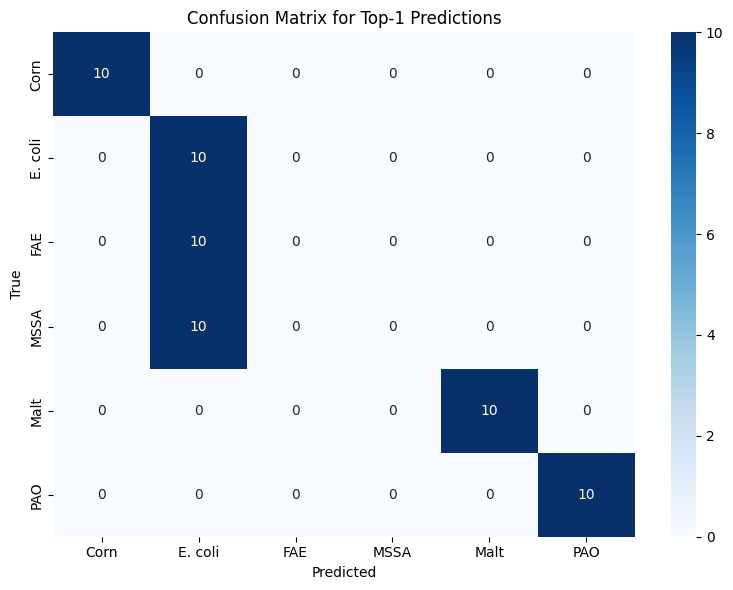

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1) Pick best model
best = res_df.iloc[0]
version    = best['version']
K_smooth   = int(best['K_smooth'])
N_peak     = int(best['N_peak'])
w_max      = int(best['w_max'])
height     = float(best['height'])
prominence = float(best['prominence'])

# 2) Re-define smooth, CaPE, extract, identify
def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

if version == 'count':
    def CaPE(refs):
        sm = np.array([smooth_spectrum(s) for s in refs])
        counts = np.zeros(sm.shape[1], int)
        for s in sm:
            pks, _ = find_peaks(s, height=height, prominence=prominence)
            counts[pks] += 1
        return sorted(np.argsort(counts)[-N_peak:])
else:
    def CaPE(refs):
        sm = np.array([smooth_spectrum(s) for s in refs])
        intens = np.zeros(sm.shape[1])
        for s in sm:
            pks, _ = find_peaks(s, height=height, prominence=prominence)
            intens[pks] += s[pks]
        return sorted(np.argsort(intens)[-N_peak:])

def extract_vec(spec, cp_idxs):
    hw = w_max // 2
    return minmax_scale([spec[max(0,i-hw):i+hw+1].max() for i in cp_idxs])

# 3) Rebuild CP library
CPs, Ref_comp = {}, {}
for chem, grp in dfR.groupby('Species'):
    cp_idxs = CaPE(grp[wavs_str].values)
    CPs[chem] = cp_idxs
    Ref_comp[chem] = np.array([extract_vec(s, cp_idxs) for s in grp[wavs_str].values])

def identify_top1(spec):
    scores = {chem: (Ref_comp[chem] @ extract_vec(spec, CPs[chem])).mean()
              for chem in CPs}
    return max(scores, key=scores.get)

# 4) True vs. Predicted
true_labels = dfQ['Species'].values
pred_labels = [identify_top1(row[wavs_str].values) for _, row in dfQ.iterrows()]

# 5) Confusion Matrix
labels = sorted(dfQ['Species'].unique())
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Top-1 Predictions')
plt.tight_layout()
plt.show()


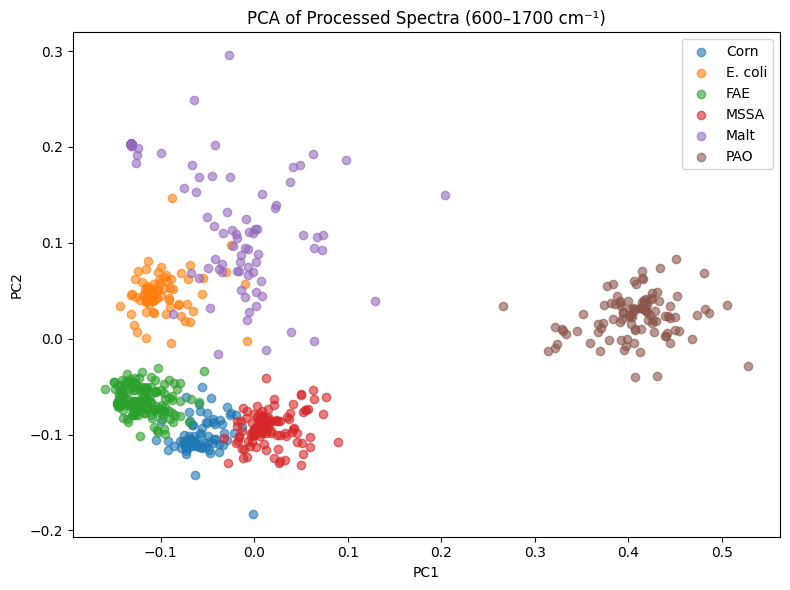

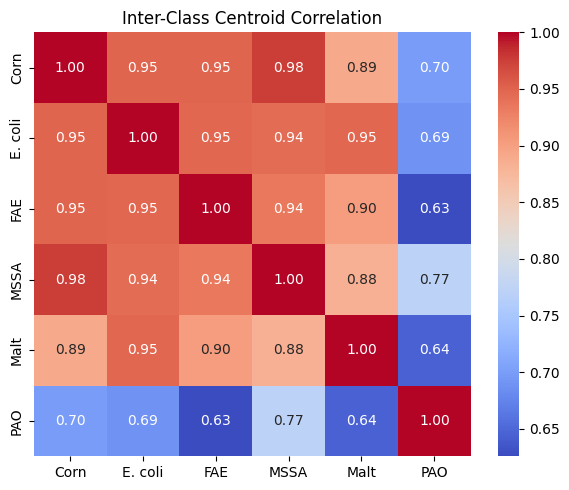

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load full dataset
df = pd.read_csv('Test_Data/Test_Data.csv')

# Identify spectral columns and species
wavs_str = df.columns[:-1]
wavs = wavs_str.astype(float)

# Crop to 600–1700 cm⁻¹
mask = (wavs >= 600) & (wavs <= 1700)
wcols = wavs_str[mask]

# Define preprocessing (baseline + l2 norm) from pipeline
def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_als(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

# Apply preprocessing
spectra = df[wcols].values.astype(float)
species = df['Species'].values
proc = preprocess(spectra)

# PCA
pca = PCA(n_components=2)
Z = pca.fit_transform(proc)

# Plot PCA scatter
plt.figure(figsize=(8,6))
for sp in np.unique(species):
    mask_sp = species == sp
    plt.scatter(Z[mask_sp,0], Z[mask_sp,1], label=sp, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Processed Spectra (600–1700 cm⁻¹)')
plt.legend()
plt.tight_layout()
plt.show()

# Compute class centroids
centroids = {}
for sp in np.unique(species):
    centroids[sp] = proc[species == sp].mean(axis=0)

# Build correlation matrix
corr_matrix = pd.DataFrame(index=centroids.keys(), columns=centroids.keys(), dtype=float)
for sp1 in centroids:
    for sp2 in centroids:
        corr = np.corrcoef(centroids[sp1], centroids[sp2])[0,1]
        corr_matrix.loc[sp1, sp2] = corr

# Display correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Inter-Class Centroid Correlation')
plt.tight_layout()
plt.show()



--- Running Benchmark for Mode: Raw Intensity Only ---
Processing Split 1...
Processing Split 2...
Processing Split 3...
Processing Split 4...
Processing Split 5...

--- Running Benchmark for Mode: Raw + 2nd Derivative ---
Processing Split 1...
Processing Split 2...
Processing Split 3...
Processing Split 4...
Processing Split 5...

--- Aggregate Results ---
| Mode      |   ('Top-1', 'mean') |   ('Top-1', 'std') |   ('Top-2', 'mean') |   ('Top-2', 'std') |
|:----------|--------------------:|-------------------:|--------------------:|-------------------:|
| Raw       |              45.67% |             13.77% |              53.00% |              8.61% |
| Raw+Deriv |              28.00% |             13.09% |              57.33% |             10.71% |

Saved plot: 'confusion_matrices_augmented.png'


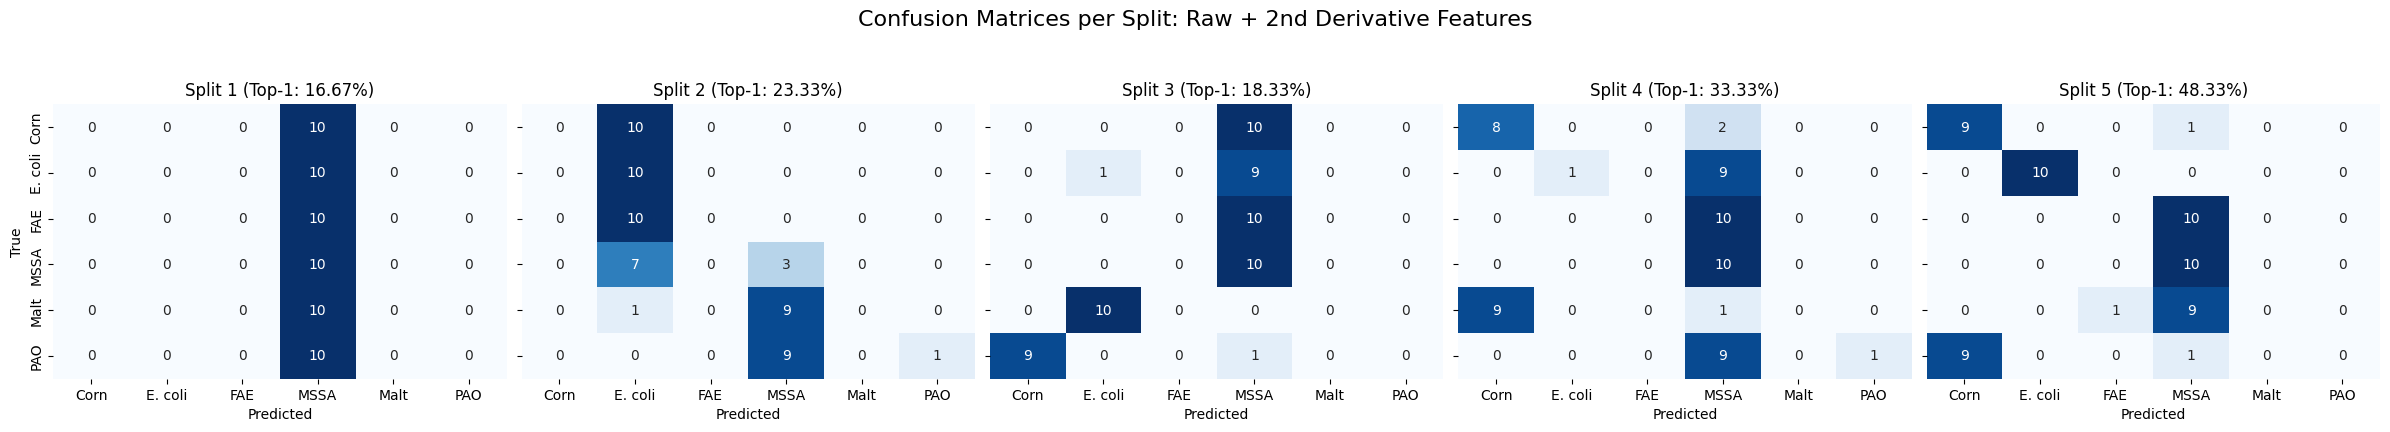

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

def identify_spectrum_pipeline(
    query_df, ref_df,
    use_derivative=False,
    crop_max=1700,
    lam=1e4, p=0.01, niter=10,
    K_smooth=3, N_peak=15, w_max=36,
    height=0.02, prominence=0.02
):
    """
    Returns list of ranked species for each query.
    If use_derivative=True, augments raw channel with 2nd derivative channel.
    """
    # --- 1) Crop to fingerprint region ---
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols)
    keep     = wav_cols[wavs_num < crop_max]
    wavs     = wavs_num[wavs_num < crop_max].values

    Q_raw = query_df[keep].values.astype(float)
    R_raw = ref_df  [keep].values.astype(float)
    R_lbl = ref_df['Species'].values

    # --- 2) Baseline removal + ℓ₂-norm ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w) + D, w * y)
            w = p * (y > b) + (1 - p) * (y < b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i, spec in enumerate(arr):
            bkg  = baseline_als(spec)
            corr = spec - bkg
            nrm  = np.linalg.norm(corr)
            out[i] = corr/nrm if nrm else corr
        return out

    Q_intensity = preprocess(Q_raw)
    R_intensity = preprocess(R_raw)

    # --- 3) Optionally compute second derivative channel ---
    if use_derivative:
        def second_derivative(spec):
            d2   = np.gradient(np.gradient(spec, wavs), wavs)
            norm = np.linalg.norm(d2)
            return d2/norm if norm else d2
        Q_deriv = np.array([second_derivative(s) for s in Q_intensity])
        R_deriv = np.array([second_derivative(s) for s in R_intensity])

    # --- 4) Smoother for both channels ---
    def smooth(arr):
        return np.convolve(arr, np.ones(K_smooth)/K_smooth, mode='same')

    # --- 5) Build CP indices and Reference Library ---
    CPs, Ref_comp = {}, {}
    for chem in np.unique(R_lbl):
        band_raw = R_intensity[R_lbl == chem]
        counts   = np.zeros(len(wavs), int)

        for spec in band_raw:
            pks, _ = find_peaks(smooth(spec), height=height, prominence=prominence)
            counts[pks] += 1

        if use_derivative:
            band_der = R_deriv[R_lbl == chem]
            for spec in band_der:
                pks, _ = find_peaks(-smooth(spec), height=height, prominence=prominence)
                counts[pks] += 1

        cp_idxs = sorted(np.argsort(counts)[-N_peak:])
        CPs[chem] = cp_idxs

        # Create compressed reference vectors
        comp = []
        hw = w_max // 2
        
        # --- FIX: Use zip to iterate over pre-calculated arrays efficiently ---
        iterator = zip(band_raw, band_der) if use_derivative else band_raw
        
        for spectra in iterator:
            if use_derivative:
                raw, der = spectra
            else:
                raw = spectra
            
            vec_raw = [raw[max(0, i-hw):i+hw+1].max() for i in cp_idxs]
            
            if use_derivative:
                vec_der = [der[max(0, i-hw):i+hw+1].max() for i in cp_idxs]
                vec = np.concatenate([vec_raw, vec_der])
            else:
                vec = vec_raw

            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.array(comp)

    # --- 6) Identification via CaPSim ---
    def CaPSim(qv, Rvs):
        return (Rvs @ qv).mean()

    all_rankings = []
    
    # --- FIX: Use zip to iterate over pre-calculated arrays efficiently ---
    iterator = zip(Q_intensity, Q_deriv) if use_derivative else Q_intensity
    
    for spectra in iterator:
        if use_derivative:
            raw, der = spectra
        else:
            raw = spectra
            
        scores = {}
        hw = w_max // 2
        for chem, cp_idxs in CPs.items():
            vec_raw = [raw[max(0, i-hw):i+hw+1].max() for i in cp_idxs]
            
            if use_derivative:
                vec_der = [der[max(0, i-hw):i+hw+1].max() for i in cp_idxs]
                vec = np.concatenate([vec_raw, vec_der])
            else:
                vec = vec_raw
                
            qv = minmax_scale(vec)
            scores[chem] = CaPSim(qv, Ref_comp[chem])
        all_rankings.append(sorted(scores, key=scores.get, reverse=True))

    return all_rankings


# === Benchmark on your 5 splits, both modes ===
def benchmark(use_deriv, title_suffix):
    print(f"\n--- Running Benchmark for Mode: {title_suffix} ---")
    split1, split2, cms = [], [], []
    try:
        labels = sorted(pd.read_csv('Test_Data/query_dataset_split1.csv')['Species'].unique())
        for i in range(1,6):
            print(f"Processing Split {i}...")
            qdf = pd.read_csv(f'Test_Data/query_dataset_split{i}.csv')
            rdf = pd.read_csv(f'Test_Data/reference_dataset_split{i}.csv')
            ranks = identify_spectrum_pipeline(qdf, rdf, use_derivative=use_deriv)
            true = qdf['Species'].values
            p1   = [r[0] for r in ranks]
            p2   = [r[:2] for r in ranks]
            split1.append(accuracy_score(true, p1))
            split2.append(np.mean([true[j] in p2[j] for j in range(len(true))]))
            cms.append(confusion_matrix(true, p1, labels=labels))
        return np.array(split1), np.array(split2), cms, labels
    except FileNotFoundError as e:
        print(f"Error: Could not find split files. Make sure they are in the correct directory. Details: {e}")
        return None, None, None, None

# Run both benchmarks
t1_raw, t2_raw, cms_raw, labels_raw = benchmark(False, "Raw Intensity Only")
t1_der, t2_der, cms_der, labels_der = benchmark(True, "Raw + 2nd Derivative")

# Summarize results if benchmarks ran successfully
if t1_raw is not None and t1_der is not None:
    df = pd.DataFrame({
        'Mode': ['Raw']*5 + ['Raw+Deriv']*5,
        'Split': list(range(1,6))*2,
        'Top-1': np.concatenate([t1_raw, t1_der]),
        'Top-2': np.concatenate([t2_raw, t2_der])
    })
    print("\n--- Aggregate Results ---")
    print(df.groupby('Mode')[['Top-1','Top-2']].agg(['mean','std']).to_markdown(floatfmt=".2%"))

    # Plot confusion matrices for Raw+Deriv
    fig, axes = plt.subplots(1,5,figsize=(24,4.5), sharey=True)
    fig.suptitle('Confusion Matrices per Split: Raw + 2nd Derivative Features', fontsize=16)
    for idx, ax in enumerate(axes):
        sns.heatmap(cms_der[idx], annot=True, fmt='d',
                    xticklabels=labels_der, yticklabels=labels_der,
                    cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f"Split {idx+1} (Top-1: {t1_der[idx]:.2%})")
        ax.set_xlabel('Predicted')
        if idx==0: ax.set_ylabel('True')
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig("confusion_matrices_augmented.png")
    print("\nSaved plot: 'confusion_matrices_augmented.png'")


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale

def identify_spectrum_pipeline(
    query_df, ref_df,
    crop_max=1700,
    lam=1e4, p=0.01, niter=10,
    K_smooth=3, N_peak=15, w_max=36,
    height=0.02, prominence=0.02
):
    # 1) Crop
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols).values
    mask     = wavs_num < crop_max
    wavs     = wavs_num[mask]
    keep     = wav_cols[mask]

    Q_raw = query_df[keep].values.astype(float)
    R_raw = ref_df  [keep].values.astype(float)
    R_lbl = ref_df['Species'].values

    # 2) Baseline + L2 norm
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam*D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i, spec in enumerate(arr):
            bkg  = baseline_als(spec)
            corr = spec - bkg
            nrm  = np.linalg.norm(corr)
            out[i] = corr/nrm if nrm else corr
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # Helper to compute area and half-width
    def area_and_width(seg, wn_seg):
        area = np.trapz(seg, wn_seg)
        peak = np.max(seg)
        half = peak / 2.0
        # indices above half
        inds = np.where(seg >= half)[0]
        if len(inds)>1:
            left, right = inds[0], inds[-1]
            width = wn_seg[right] - wn_seg[left]
        else:
            width = 0.0
        return area, width

    # 3) Smooth helper
    def smooth(x): 
        return np.convolve(x, np.ones(K_smooth)/K_smooth, mode='same')

    # 4) Build CPs
    CPs, Ref_comp = {}, {}
    for chem in np.unique(R_lbl):
        band = R[R_lbl==chem]
        counts = np.zeros(len(wavs), int)
        for spec in band:
            sm = smooth(spec)
            pks, _ = find_peaks(sm, height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = sorted(np.argsort(counts)[-N_peak:])
        CPs[chem] = cp_idxs

        # 5) Compress references
        comp = []
        halfw = w_max//2
        for spec in band:
            feats = []
            for i in cp_idxs:
                # segment wavenumbers and intensities
                left = max(0, i-halfw)
                right= min(len(spec), i+halfw+1)
                seg   = spec[left:right]
                wn_seg= wavs[left:right]
                peak  = np.max(seg)
                area, width = area_and_width(seg, wn_seg)
                feats.extend([peak, area, width])
            comp.append(minmax_scale(feats))
        Ref_comp[chem] = np.array(comp)

    # 6) Identify
    def CaPSim(qv, Rvs): 
        return (Rvs @ qv).mean()

    all_rankings = []
    halfw = w_max//2
    for spec in Q:
        scores = {}
        for chem, cp_idxs in CPs.items():
            feats = []
            for i in cp_idxs:
                left = max(0, i-halfw)
                right= min(len(spec), i+halfw+1)
                seg   = spec[left:right]
                wn_seg= wavs[left:right]
                peak  = np.max(seg)
                area, width = area_and_width(seg, wn_seg)
                feats.extend([peak, area, width])
            qv = minmax_scale(feats)
            scores[chem] = CaPSim(qv, Ref_comp[chem])
        all_rankings.append(sorted(scores, key=scores.get, reverse=True))

    return all_rankings


   Split     Top-1     Top-2
0      1  0.666667  0.683333
1      2  0.316667  0.483333
2      3  0.466667  0.500000
3      4  0.483333  0.500000
4      5  0.483333  0.483333

Mean Top-1: 48.33% ± 12.42%
Mean Top-2: 53.00% ± 8.61%


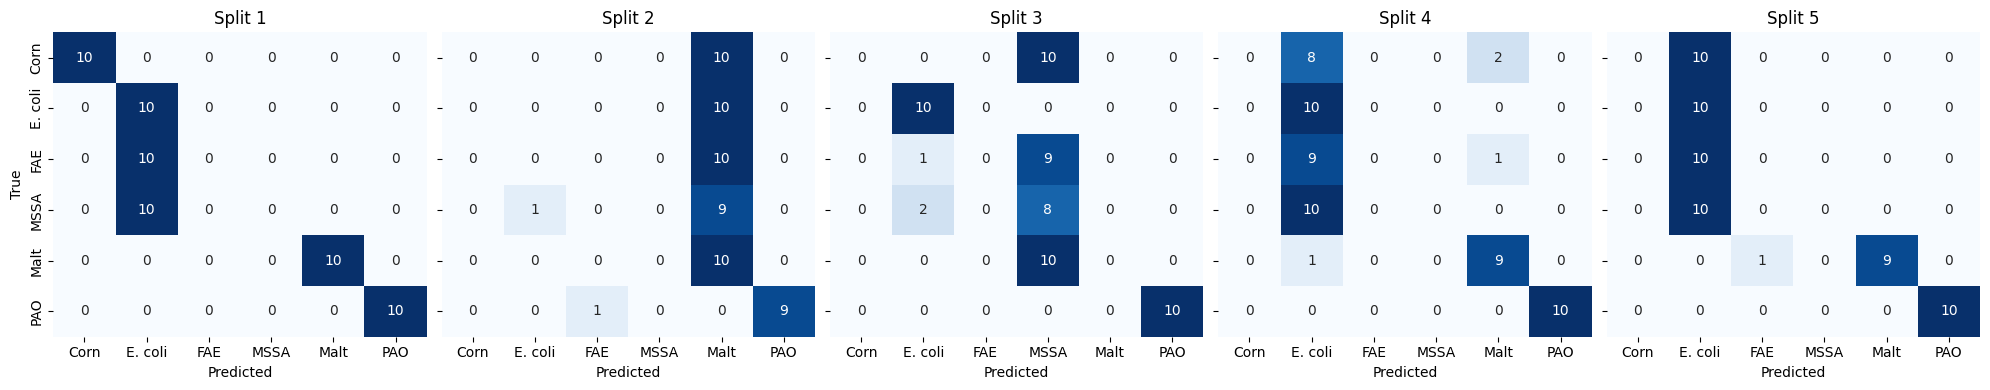

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from scipy.stats import pearsonr

def identify_spectrum_pipeline(
    query_df, ref_df,
    crop_max=1700,
    lam=1e4, p=0.01, niter=10,
    K_smooth=3, N_peak=15, w_max=36,
    height=0.02, prominence=0.02,
    alpha=0.7  # weight on CaPSim; (1-alpha)=weight on correlation
):
    # 1) Crop
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols)
    keep     = wav_cols[wavs_num < crop_max]
    wavs     = wavs_num[wavs_num < crop_max].values

    Q_raw = query_df[keep].values.astype(float)
    R_raw = ref_df  [keep].values.astype(float)
    R_lbl = ref_df['Species'].values

    # 2) Baseline + L2 norm
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L),2); D = lam*D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,spec in enumerate(arr):
            bkg  = baseline_als(spec)
            corr = spec - bkg
            nrm  = np.linalg.norm(corr)
            out[i] = corr/nrm if nrm else corr
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # 3) Smooth + CP library
    def smooth(x):
        return np.convolve(x, np.ones(K_smooth)/K_smooth, mode='same')

    CPs, Ref_comp, Ref_means = {}, {}, {}
    for chem in np.unique(R_lbl):
        band = R[R_lbl==chem]
        counts = np.zeros(len(wavs), int)
        for spec in band:
            sm = smooth(spec)
            pks, _ = find_peaks(sm, height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = sorted(np.argsort(counts)[-N_peak:])
        CPs[chem] = cp_idxs

        # build compressed-ref vectors
        comp = []
        hw = w_max//2
        for spec in band:
            vec = [ spec[max(0,i-hw):i+hw+1].max() for i in cp_idxs ]
            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.array(comp)

        # store the per-species centroid for correlation
        Ref_means[chem] = band.mean(axis=0)

    # 4) Identify with ensemble score
    def CaPSim(qv, Rvs):
        return (Rvs @ qv).mean()

    all_rankings = []
    for spec in Q:
        scores = {}
        hw = w_max//2

        for chem, cp_idxs in CPs.items():
            # 4a) CaPSim part
            vec = [ spec[max(0,i-hw):i+hw+1].max() for i in cp_idxs ]
            qv  = minmax_scale(vec)
            s1  = CaPSim(qv, Ref_comp[chem])

            # 4b) Pearson correlation part
            # both spec and Ref_means[chem] are already ℓ₂‐normalized
            s2, _ = pearsonr(spec, Ref_means[chem])

            # 4c) ensemble
            score = alpha * s1 + (1-alpha) * s2
            scores[chem] = score

        ranking = sorted(scores, key=scores.get, reverse=True)
        all_rankings.append(ranking)

    return all_rankings


# === Benchmark on 5 splits ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

split_top1, split_top2, split_cms = [], [], []
labels = sorted(pd.read_csv('Test_Data/query_dataset_split1.csv')['Species'].unique())

for i in range(1,6):
    qdf = pd.read_csv(f'Test_Data/query_dataset_split{i}.csv')
    rdf = pd.read_csv(f'Test_Data/Reference_dataset_split{i}.csv')
    ranks = identify_spectrum_pipeline(qdf, rdf, alpha=0.7)

    true  = qdf['Species'].values
    p1    = [r[0] for r in ranks]
    p2    = [r[:2] for r in ranks]
    split_top1.append(accuracy_score(true, p1))
    split_top2.append(np.mean([true[j] in p2[j] for j in range(len(true))]))
    split_cms.append(confusion_matrix(true, p1, labels=labels))

# summarise
df = pd.DataFrame({
    'Split': range(1,6),
    'Top-1': split_top1,
    'Top-2': split_top2
})
print(df)
print(f"\nMean Top-1: {df['Top-1'].mean():.2%} ± {df['Top-1'].std():.2%}")
print(f"Mean Top-2: {df['Top-2'].mean():.2%} ± {df['Top-2'].std():.2%}")

# confusion plots (optional)
fig, axes = plt.subplots(1,5,figsize=(20,4), sharey=True)
for idx, ax in enumerate(axes):
    sns.heatmap(split_cms[idx], annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels,
                cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"Split {idx+1}")
    ax.set_xlabel('Predicted')
    if idx==0: ax.set_ylabel('True')
plt.tight_layout()
plt.show()


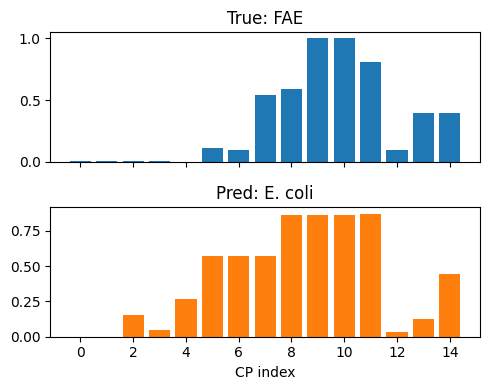

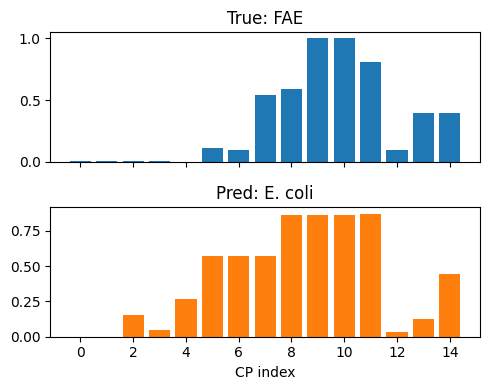

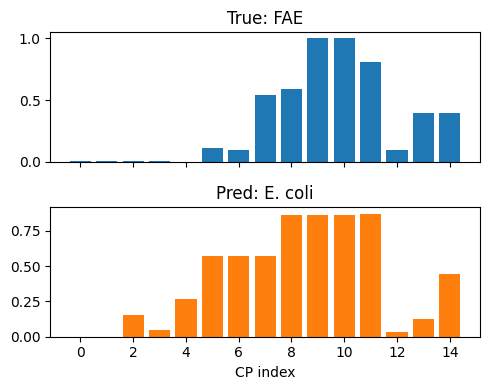

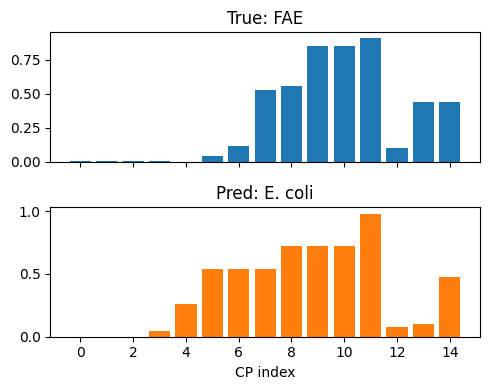

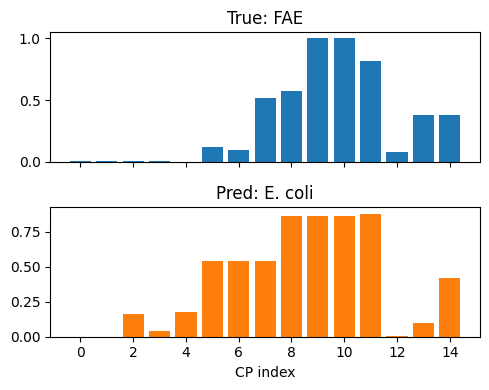

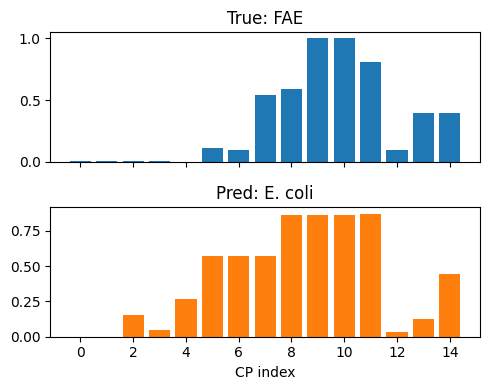

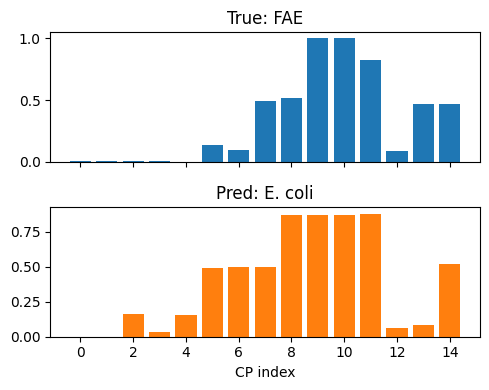

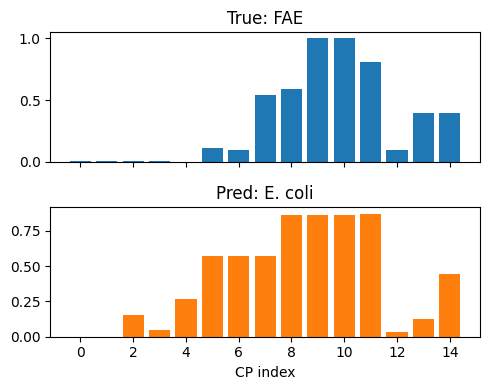

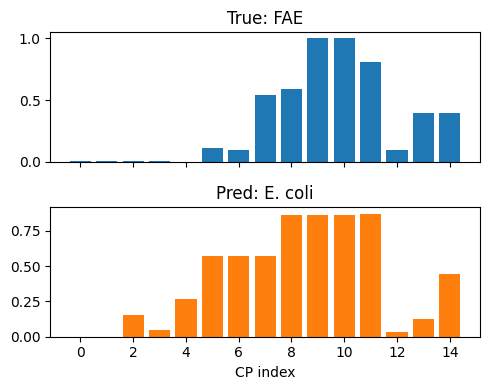

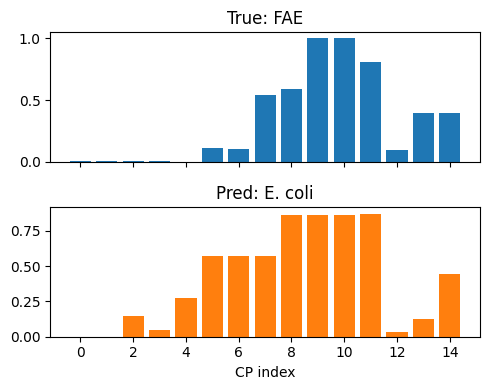

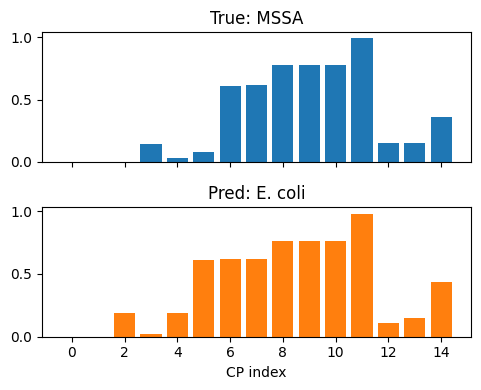

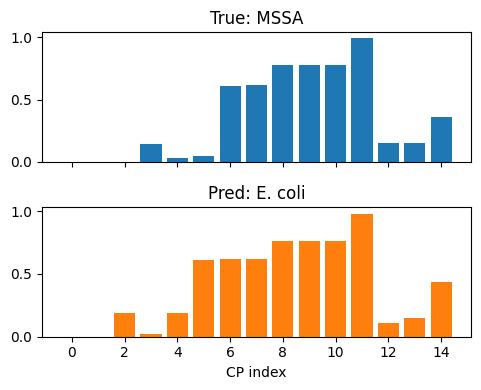

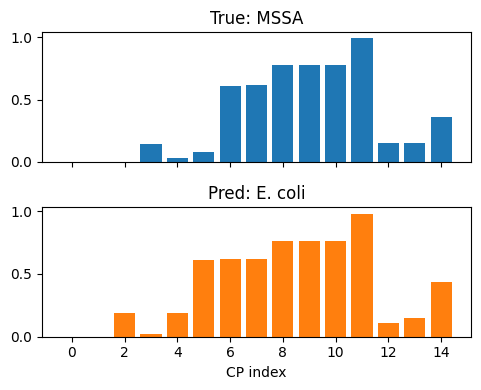

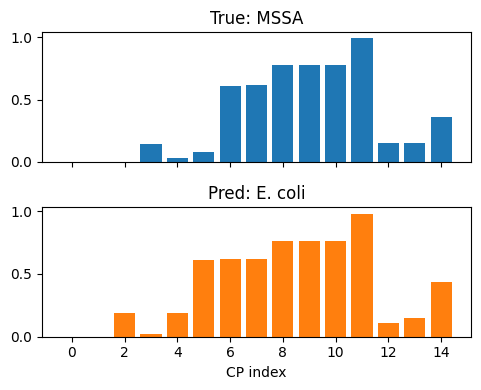

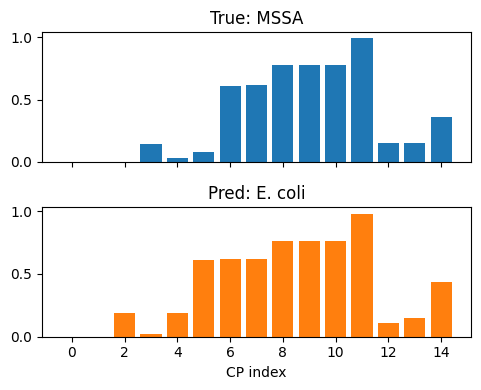

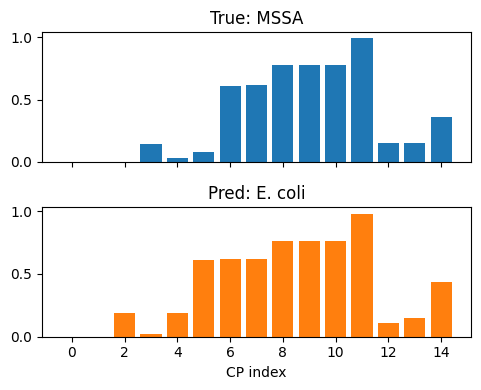

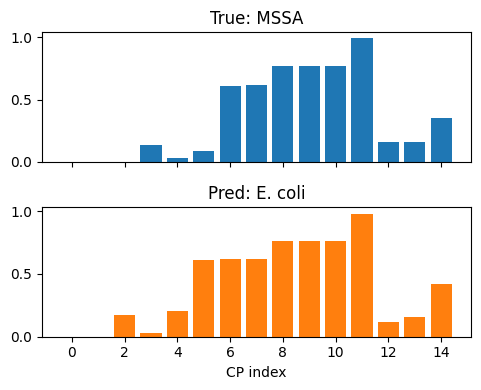

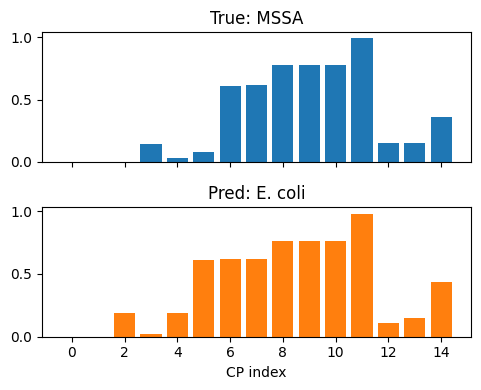

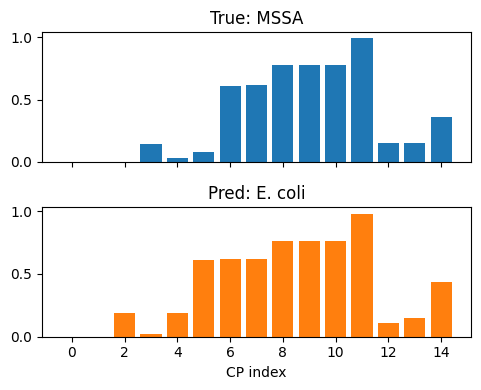

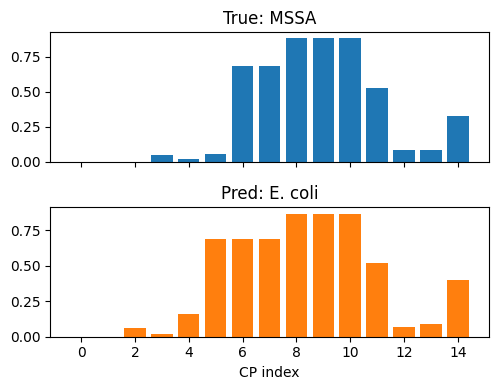

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale

def identify_spectrum_pipeline(query_df, ref_df, crop_max=1700, lam=1e4, p=0.01, niter=10, K_smooth=3, N_peak=15, w_max=36, height=0.02, prominence=0.02):
    """
    Returns a list of lists: each inner list is the species ranked
    by descending CaPSim score (Top-1 at index 0, Top-2 at index 1).
    """
    # --- crop ---
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols)
    keep     = wav_cols[wavs_num < crop_max]
    wavs     = wavs_num[wavs_num < crop_max].values

    q = query_df[keep].values.astype(float)
    r = ref_df  [keep].values.astype(float)
    r_lbl = ref_df['Species'].values

    # --- preprocess ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w) + D, w * y)
            w = p * (y > b) + (1 - p) * (y < b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i, spec in enumerate(arr):
            bkg  = baseline_als(spec)
            corr = spec - bkg
            nrm  = np.linalg.norm(corr)
            out[i] = corr/nrm if nrm else corr
        return out

    Q = preprocess(q)
    R = preprocess(r)

    # --- smooth + CP library ---
    def smooth(spec):
        return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

    CPs, Ref_comp = {}, {}
    for chem in np.unique(r_lbl):
        refs = R[r_lbl == chem]
        counts = np.zeros(len(wavs), int)
        for spec in refs:
            sm = smooth(spec)
            pks, _ = find_peaks(sm, height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = sorted(np.argsort(counts)[-N_peak:])
        CPs[chem] = cp_idxs

        comp = []
        for spec in refs:
            vec = []
            hw  = w_max//2
            for i in cp_idxs:
                seg = spec[max(0,i-hw):i+hw+1]
                vec.append(np.max(seg))
            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.array(comp)

    # --- identification: return full ranking per query ---
    def CaPSim(qv, Rvs):
        return (Rvs @ qv).mean()

    all_rankings = []
    for spec in Q:
        scores = {}
        for chem, cp_idxs in CPs.items():
            vec = []
            hw  = w_max//2
            for i in cp_idxs:
                seg = spec[max(0,i-hw):i+hw+1]
                vec.append(np.max(seg))
            qv = minmax_scale(vec)
            scores[chem] = CaPSim(qv, Ref_comp[chem])
        # sorted chems high→low
        ranking = sorted(scores, key=scores.get, reverse=True)
        all_rankings.append(ranking)

    return all_rankings, Q, CPs, Ref_comp


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# 1) Benchmark all splits to find the best one
split_top1 = []
for i in range(1,6):
    qdf = pd.read_csv(f'Test_Data/query_dataset_split{i}.csv')
    rdf = pd.read_csv(f'Test_Data/reference_dataset_split{i}.csv')
    ranks, _, _, _ = identify_spectrum_pipeline(qdf, rdf)
    true = qdf['Species'].values
    pred = [r[0] for r in ranks]
    split_top1.append(accuracy_score(true, pred))

best_split = int(np.argmax(split_top1)) + 1

# 2) Rerun on the best split, unpacking Q, CPs, Ref_comp
qdf = pd.read_csv(f'Test_Data/query_dataset_split{best_split}.csv')
rdf = pd.read_csv(f'Test_Data/reference_dataset_split{best_split}.csv')
ranks, Q, CPs, Ref_comp = identify_spectrum_pipeline(qdf, rdf)

true  = qdf['Species'].values
pred1 = [r[0] for r in ranks]

# ─── HERE: Error analysis via AttrCaPSim ───
mean_ref = {chem: Ref_comp[chem].mean(axis=0) for chem in Ref_comp}
mis_idx  = [j for j,(t,p) in enumerate(zip(true,pred1)) if t!=p]

hw = w_max//2
for j in mis_idx:
    spec  = Q[j]
    tchem, pchem = true[j], pred1[j]
    cp_t, cp_p   = CPs[tchem], CPs[pchem]

    def make_qv(sp, cp_idxs):
        return minmax_scale([sp[max(0,i-hw):i+hw+1].max() for i in cp_idxs])

    qv_t = make_qv(spec, cp_t)
    qv_p = make_qv(spec, cp_p)
    rv_t = mean_ref[tchem]
    rv_p = mean_ref[pchem]

    attr_t = qv_t * rv_t
    attr_p = qv_p * rv_p

    # Plot
    fig, ax = plt.subplots(2,1,figsize=(5,4), sharex=True)
    ks = np.arange(len(attr_t))
    ax[0].bar(ks, attr_t); ax[0].set_title(f"True: {tchem}")
    ax[1].bar(ks, attr_p, color='C1'); ax[1].set_title(f"Pred: {pchem}")
    ax[1].set_xlabel("CP index")
    plt.tight_layout()
    plt.show()
# ─── END error analysis ───

# 3) (Optionally) Continue with any reporting or exit


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale

def identify_spectrum_pipeline(query_df, ref_df, crop_max=2500, lam=1e4, p=0.01, niter=10, K_smooth=3, N_peak=15, w_max=36, height=0.02, prominence=0.02):
    """
    Returns a list of lists: each inner list is the species ranked
    by descending CaPSim score (Top-1 at index 0, Top-2 at index 1).
    """
    # --- crop ---
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols)
    keep     = wav_cols[wavs_num < crop_max]
    wavs     = wavs_num[wavs_num < crop_max].values

    q = query_df[keep].values.astype(float)
    r = ref_df  [keep].values.astype(float)
    r_lbl = ref_df['Label'].values

    # --- preprocess ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w) + D, w * y)
            w = p * (y > b) + (1 - p) * (y < b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i, spec in enumerate(arr):
            bkg  = baseline_als(spec)
            corr = spec - bkg
            nrm  = np.linalg.norm(corr)
            out[i] = corr/nrm if nrm else corr
        return out

    Q = preprocess(q)
    R = preprocess(r)

    # --- smooth + CP library ---
    def smooth(spec):
        return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

    CPs, Ref_comp = {}, {}
    for chem in np.unique(r_lbl):
        refs = R[r_lbl == chem]
        counts = np.zeros(len(wavs), int)
        for spec in refs:
            sm = smooth(spec)
            pks, _ = find_peaks(sm, height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = sorted(np.argsort(counts)[-N_peak:])
        CPs[chem] = cp_idxs

        comp = []
        for spec in refs:
            vec = []
            hw  = w_max//2
            for i in cp_idxs:
                seg = spec[max(0,i-hw):i+hw+1]
                vec.append(np.max(seg))
            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.array(comp)

    # --- identification: return full ranking per query ---
    def CaPSim(qv, Rvs):
        return (Rvs @ qv).mean()

    all_rankings = []
    for spec in Q:
        scores = {}
        for chem, cp_idxs in CPs.items():
            vec = []
            hw  = w_max//2
            for i in cp_idxs:
                seg = spec[max(0,i-hw):i+hw+1]
                vec.append(np.max(seg))
            qv = minmax_scale(vec)
            scores[chem] = CaPSim(qv, Ref_comp[chem])
        # sorted chems high→low
        ranking = sorted(scores, key=scores.get, reverse=True)
        all_rankings.append(ranking)

    return all_rankings




In [ ]:
# 1. Load your data
query_df = pd.read_csv("Jesse Dataset/query.csv")
ref_df   = pd.read_csv("Jesse Dataset/reference.csv")

# 2. Get the ranked predictions for each query
rankings = identify_spectrum_pipeline(query_df, ref_df)

# 3. Extract the true labels from your query set
true_labels = query_df["Label"].tolist()

# 4. Compute Top-k accuracy for k = 1…5
n_queries = len(true_labels)
for k in range(1, 6):
    n_correct = sum(
        1 for true, rank in zip(true_labels, rankings)
        if true in rank[:k]
    )
    acc = n_correct / n_queries
    print(f"Top-{k} accuracy: {acc:.2%}")


Top-1 accuracy: 16.67%
Top-2 accuracy: 25.00%
Top-3 accuracy: 33.33%
Top-4 accuracy: 41.67%
Top-5 accuracy: 58.33%


Top-1 Accuracy: 25.00%
Top-2 Accuracy: 66.67%


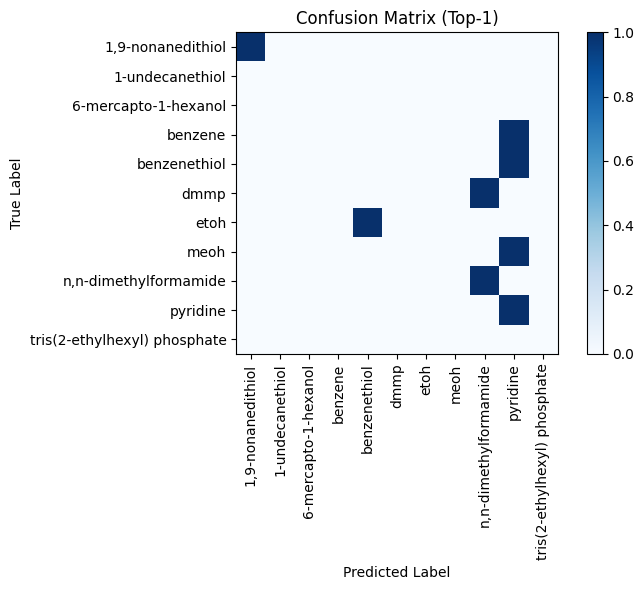

In [29]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# 1. Load data
ref_df = pd.read_csv('Jesse_Dataset/reference.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')

# Ensure label column named 'Label'
if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df = ref_df.rename(columns={'Species': 'Label'})
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df = query_df.rename(columns={'Species': 'Label'})

# 2. Define the pipeline
def identify_spectrum_pipeline(query_df, ref_df, crop_max=2500, lam=1e4, p=0.01, niter=10, 
                               K_smooth=3, N_peak=15, w_max=36, height=None, prominence=None):
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols)
    keep     = wav_cols[wavs_num < crop_max]

    q = query_df[keep].values.astype(float)
    r = ref_df[keep].values.astype(float)
    r_lbl = ref_df['Label'].values

    # Baseline ALS & preprocess
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w) + D, w * y)
            w = p * (y > b) + (1 - p) * (y < b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i, spec in enumerate(arr):
            bkg  = baseline_als(spec)
            corr = spec - bkg
            nrm  = np.linalg.norm(corr)
            out[i] = corr/nrm if nrm else corr
        return out

    Q = preprocess(q)
    R = preprocess(r)

    # Build CP library
    def smooth(spec):
        return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

    CPs, Ref_comp = {}, {}
    for chem in np.unique(r_lbl):
        refs = R[r_lbl == chem]
        counts = np.zeros(Q.shape[1], int)
        for spec in refs:
            sm = smooth(spec)
            pks, _ = find_peaks(sm, height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = sorted(np.argsort(counts)[-N_peak:])
        CPs[chem] = cp_idxs

        comp = []
        for spec in refs:
            vec = []
            hw  = w_max//2
            for i in cp_idxs:
                seg = spec[max(0,i-hw):i+hw+1]
                vec.append(np.max(seg))
            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.array(comp)

    # Identification
    def CaPSim(qv, Rvs):
        return (Rvs @ qv).mean()

    all_rankings = []
    for spec in Q:
        scores = {}
        for chem in CPs:
            vec = []
            hw  = w_max//2
            for i in CPs[chem]:
                seg = spec[max(0,i-hw):i+hw+1]
                vec.append(np.max(seg))
            qv = minmax_scale(vec)
            scores[chem] = CaPSim(qv, Ref_comp[chem])
        ranking = sorted(scores, key=scores.get, reverse=True)
        all_rankings.append(ranking)
    
    return all_rankings, Q, CPs, Ref_comp

# Run pipeline
rankings, Q, CPs, Ref_comp = identify_spectrum_pipeline(query_df, ref_df)

# Extract true and predicted labels
true_labels = query_df['Label'].values
predicted_top1 = [r[0] for r in rankings]
predicted_top2 = [r[1] for r in rankings]

# Compute accuracies
acc_top1 = accuracy_score(true_labels, predicted_top1)
acc_top2 = np.mean([true == pred2 or true == pred1 for true, pred1, pred2 in zip(true_labels, predicted_top1, predicted_top2)])

print(f"Top-1 Accuracy: {acc_top1:.2%}")
print(f"Top-2 Accuracy: {acc_top2:.2%}")

# Confusion matrix heatmap
labels = np.unique(true_labels)
cm = confusion_matrix(true_labels, predicted_top1, labels=labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix (Top-1)")
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()




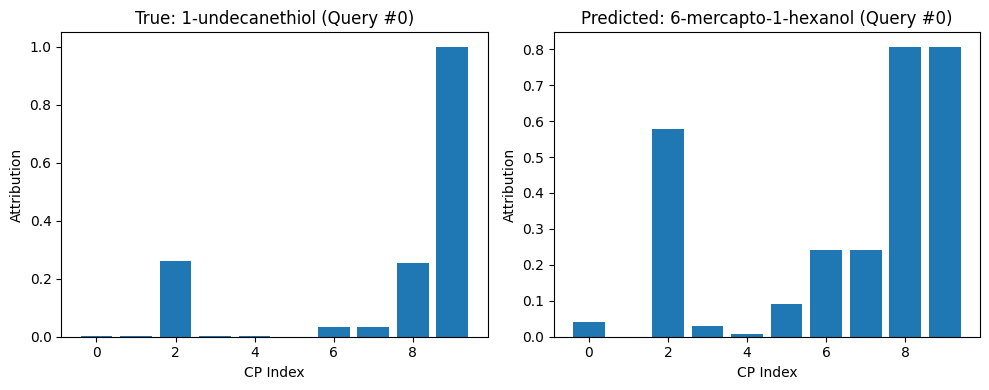

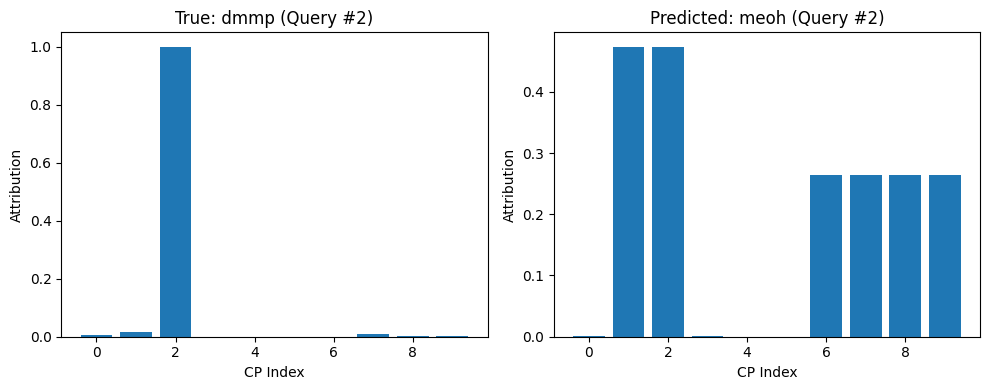

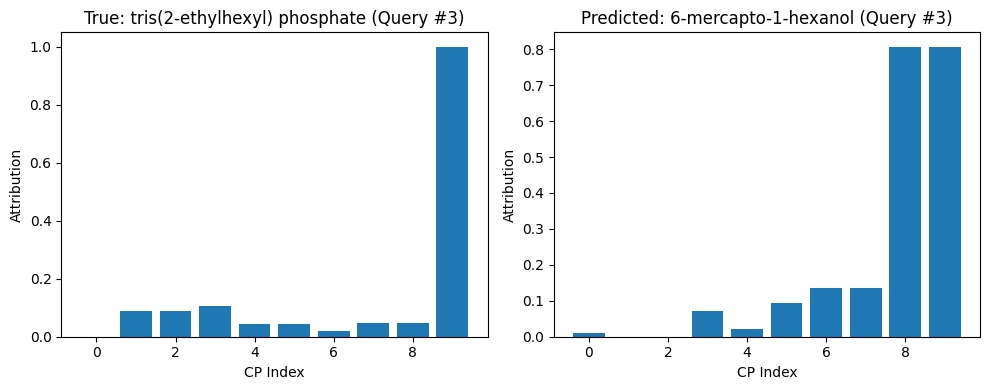

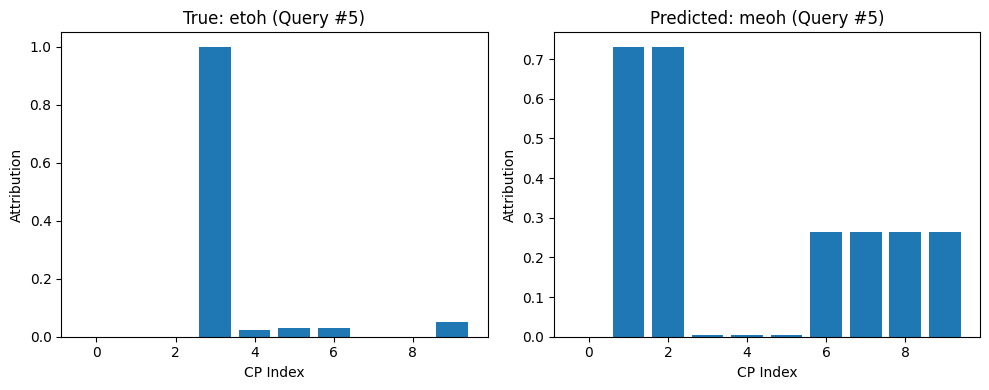

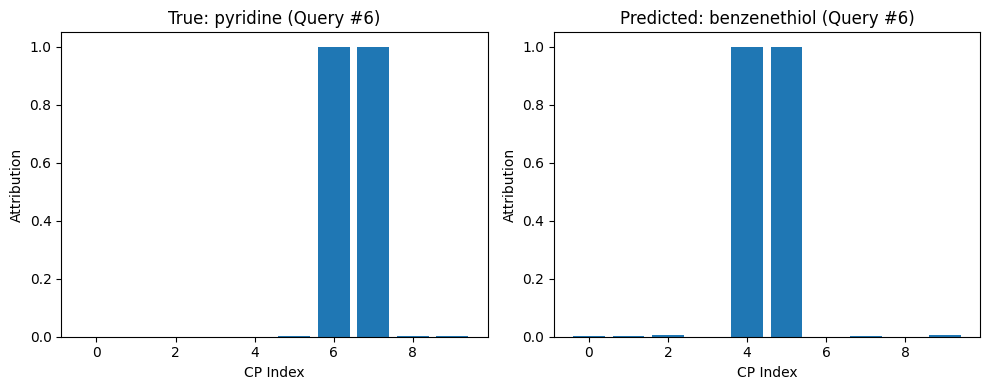

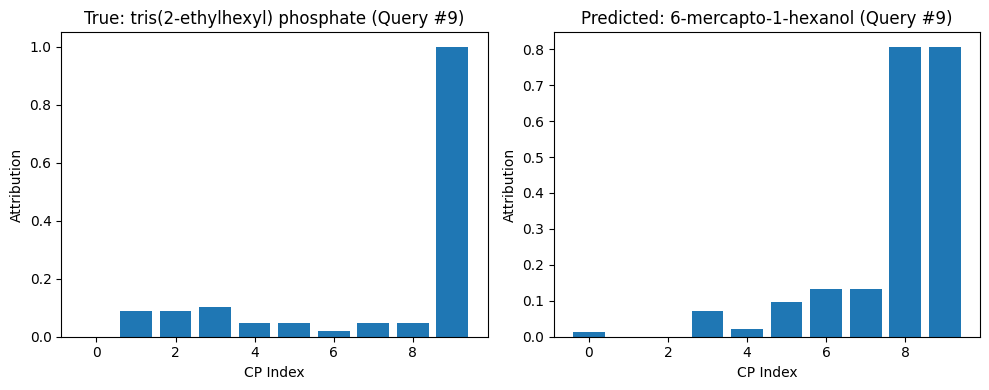

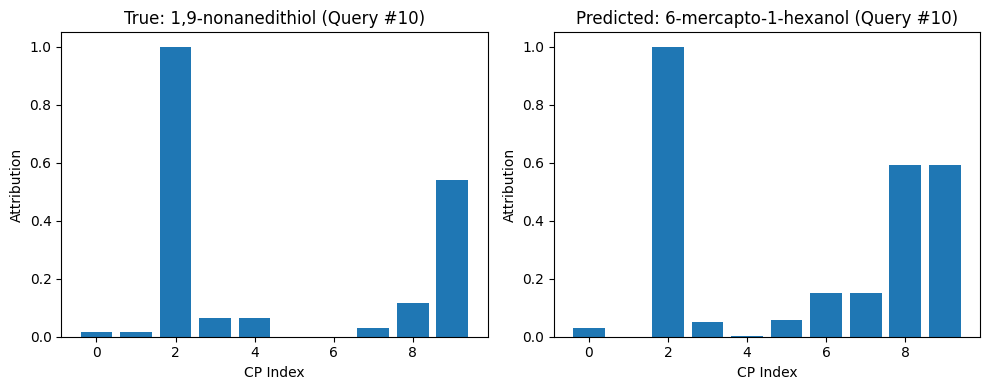

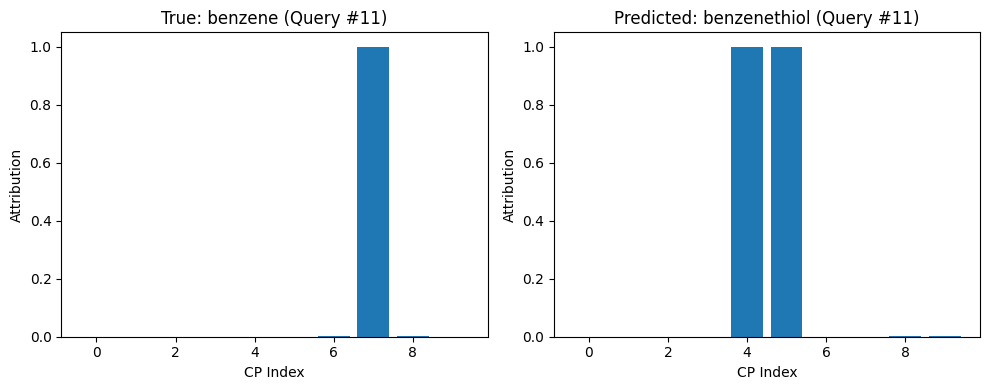

In [20]:
# Error analysis for misclassifications
mean_ref_vectors = {chem: Ref_comp[chem].mean(axis=0) for chem in Ref_comp}
w_max = 36
misclassified_indices = [i for i, (t, p) in enumerate(zip(true_labels, predicted_top1)) if t != p]

for idx in misclassified_indices:
    true_chem = true_labels[idx]
    pred_chem = predicted_top1[idx]
    spec = Q[idx]
    
    # Attribution for true class
    qv_true = minmax_scale([np.max(spec[max(0, i-(w_max//2)):i+(w_max//2)+1]) for i in CPs[true_chem]])
    attr_true = qv_true * mean_ref_vectors[true_chem]
    
    # Attribution for predicted class
    qv_pred = minmax_scale([np.max(spec[max(0, i-(w_max//2)):i+(w_max//2)+1]) for i in CPs[pred_chem]])
    attr_pred = qv_pred * mean_ref_vectors[pred_chem]

    # Plot pair of bar charts
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(attr_true)), attr_true)
    plt.title(f"True: {true_chem} (Query #{idx})")
    plt.xlabel("CP Index")
    plt.ylabel("Attribution")

    plt.subplot(1, 2, 2)
    plt.bar(range(len(attr_pred)), attr_pred)
    plt.title(f"Predicted: {pred_chem} (Query #{idx})")
    plt.xlabel("CP Index")
    plt.ylabel("Attribution")

    plt.tight_layout()
    plt.show()

In [5]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score


# Load data
ref_df = pd.read_csv('Jesse_Dataset/reference_subset_5.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')
if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species': 'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species': 'Label'}, inplace=True)

# Define pipeline function
def identify_spectrum_pipeline(query_df, ref_df, K_smooth, N_peak, w_max, height, prominence,
                               crop_max=1500, lam=1e4, p=0.01, niter=10):
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols)
    keep = wav_cols[wavs_num < crop_max]
    q = query_df[keep].values.astype(float)
    r = ref_df[keep].values.astype(float)
    r_lbl = ref_df['Label'].values

    # ALS baseline + normalization
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2)
        D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w) + D, w * y)
            w = p * (y > b) + (1 - p) * (y < b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i, spec in enumerate(arr):
            bkg = baseline_als(spec)
            corr = spec - bkg
            norm = np.linalg.norm(corr)
            out[i] = corr / norm if norm else corr
        return out

    Q = preprocess(q)
    R = preprocess(r)

    def smooth(spec):
        return np.convolve(spec, np.ones(K_smooth) / K_smooth, mode='same')

    CPs, Ref_comp = {}, {}
    for chem in np.unique(r_lbl):
        refs = R[r_lbl == chem]
        counts = np.zeros(Q.shape[1], int)
        for spec in refs:
            sm = smooth(spec)
            pks, _ = find_peaks(sm, height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = sorted(np.argsort(counts)[-N_peak:])
        CPs[chem] = cp_idxs
        comp = []
        for spec in refs:
            vec = [np.max(spec[max(0, i - w_max//2):i + w_max//2 + 1]) for i in cp_idxs]
            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.array(comp)

    # Identification
    rankings = []
    for spec in Q:
        scores = {}
        for chem, cp_idxs in CPs.items():
            vec = [np.max(spec[max(0, i - w_max//2):i + w_max//2 + 1]) for i in cp_idxs]
            qv = minmax_scale(vec)
            scores[chem] = (Ref_comp[chem] @ qv).mean()
        ranking = sorted(scores, key=scores.get, reverse=True)
        rankings.append(ranking)
    return rankings

# Hyperparameter grid
K_vals = [3]
N_vals = [12]
W_vals = [15]
height_vals = [None,0.01,0.015]
prominence_vals = height_vals

results = []
for K in K_vals:
    for N in N_vals:
        for W in W_vals:
            for h in height_vals:
                for pr in prominence_vals:
                    rankings = identify_spectrum_pipeline(query_df, ref_df,
                                                           K_smooth=K, N_peak=N,
                                                           w_max=W, height=h, prominence=pr)
                    true = query_df['Label'].values
                    pred1 = [r[0] for r in rankings]
                    pred2 = [r[1] for r in rankings]
                    top1 = accuracy_score(true, pred1)
                    top2 = np.mean([t in (p1, p2) for t, p1, p2 in zip(true, pred1, pred2)])
                    results.append({
                        'K_smooth': K, 'N_peak': N, 'w_max': W,
                        'height': h, 'prominence': pr,
                        'top1_acc': round(top1, 4),
                        'top2_acc': round(top2, 4)
                    })

# Build DataFrame and show top 5
res_df = pd.DataFrame(results)
res_df = res_df.sort_values(['top1_acc', 'top2_acc'], ascending=False).head(5).reset_index(drop=True)

# Display in markdown and interactive table
print("## Top 5 CaPE Parameter Settings\n")
print(res_df.to_markdown(index=False))



## Top 5 CaPE Parameter Settings

|   K_smooth |   N_peak |   w_max |   height |   prominence |   top1_acc |   top2_acc |
|-----------:|---------:|--------:|---------:|-------------:|-----------:|-----------:|
|          3 |       12 |      15 |    0.015 |      nan     |     0.5    |     0.6667 |
|          3 |       12 |      15 |  nan     |      nan     |     0.4167 |     0.75   |
|          3 |       12 |      15 |    0.01  |      nan     |     0.3333 |     0.8333 |
|          3 |       12 |      15 |  nan     |        0.01  |     0.1667 |     0.5833 |
|          3 |       12 |      15 |  nan     |        0.015 |     0.1667 |     0.5833 |


In [40]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score


# 1. Load data
ref_df = pd.read_csv('Jesse_Dataset/reference_subset_1.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')

if 'Label' not in ref_df.columns and 'Species' in ref_df.columns:
    ref_df.rename(columns={'Species':'Label'}, inplace=True)
if 'Label' not in query_df.columns and 'Species' in query_df.columns:
    query_df.rename(columns={'Species':'Label'}, inplace=True)

def identify_spectrum_pipeline(query_df, ref_df,
    crop_max=1500, lam=1e4, p=0.01, niter=10,
    K_smooth=3, N_peak=12, w_max=15,
    height=0.01, prominence=0.01):

    # --- prepare data matrices ---
    wav_cols = query_df.columns[:-1]
    wavs_num = pd.to_numeric(wav_cols)
    keep     = wav_cols[wavs_num < crop_max]
    Q_raw = query_df[keep].values.astype(float)
    R_raw = ref_df  [keep].values.astype(float)
    labels = ref_df['Label'].values
    classes = np.unique(labels)
    n_classes = len(classes)

    # --- baseline & normalize ---
    def baseline_als(y):
        L = len(y)
        D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
        w = np.ones(L)
        for _ in range(niter):
            b = np.linalg.solve(np.diag(w)+D, w*y)
            w = p*(y>b) + (1-p)*(y<b)
        return b

    def preprocess(arr):
        out = np.zeros_like(arr)
        for i,s in enumerate(arr):
            b = baseline_als(s)
            c = s - b
            out[i] = c/np.linalg.norm(c) if np.linalg.norm(c)>0 else c
        return out

    Q = preprocess(Q_raw)
    R = preprocess(R_raw)

    # --- smooth helper ---
    def smooth(x):
        return np.convolve(x, np.ones(K_smooth)/K_smooth, mode='same')

    # --- 1) build raw peak counts per class ---
    counts_by_class = {chem: np.zeros(Q.shape[1], int)
                       for chem in classes}
    for chem in classes:
        specs = R[labels==chem]
        cnt  = counts_by_class[chem]
        for s in specs:
            pks, _ = find_peaks(smooth(s), height=height, prominence=prominence)
            cnt[pks] += 1

    # --- 2) compute document frequency and idf ---
    df = np.zeros(Q.shape[1], int)
    for i in range(Q.shape[1]):
        # count number of classes where this index ever lit up
        df[i] = sum(1 for chem in classes if counts_by_class[chem][i] > 0)
    idf = np.log(n_classes / (1 + df))

    # --- 3) pick TF–IDF peaks & build reference comps ---
    CPs, Ref_comp = {}, {}
    for chem in classes:
        tf = counts_by_class[chem].astype(float)
        tfidf = tf * idf                   # elementwise TF–IDF score
        idxs = np.argsort(tfidf)[-N_peak:] # top N_peak TF–IDF indices
        CPs[chem] = sorted(idxs)

        # now extract intensity vectors at these CPs
        comp = []
        for s in R[labels==chem]:
            vec = [ np.max(s[max(0,i-w_max//2):i+w_max//2+1])
                    for i in CPs[chem] ]
            comp.append(minmax_scale(vec))
        Ref_comp[chem] = np.vstack(comp)

    # --- 4) identification by mean dot product ---
    rankings = []
    for s in Q:
        scores = {}
        for chem in classes:
            vec = [ np.max(s[max(0,i-w_max//2):i+w_max//2+1])
                    for i in CPs[chem] ]
            qv  = minmax_scale(vec)
            scores[chem] = (Ref_comp[chem] @ qv).mean()
        rankings.append(sorted(scores, key=scores.get, reverse=True))

    return rankings

# Hyperparameter grid
K_vals = [3]
N_vals = [12]
W_vals = [15]
height_vals = [0.01]
prominence_vals = height_vals

results = []
for K in K_vals:
    for N in N_vals:
        for W in W_vals:
            for h in height_vals:
                for pr in prominence_vals:
                    rankings = identify_spectrum_pipeline(query_df, ref_df,
                                                           K_smooth=K, N_peak=N,
                                                           w_max=W, height=h, prominence=pr)
                    true = query_df['Label'].values
                    pred1 = [r[0] for r in rankings]
                    pred2 = [r[1] for r in rankings]
                    top1 = accuracy_score(true, pred1)
                    top2 = np.mean([t in (p1, p2) for t, p1, p2 in zip(true, pred1, pred2)])
                    results.append({
                        'K_smooth': K, 'N_peak': N, 'w_max': W,
                        'height': h, 'prominence': pr,
                        'top1_acc': round(top1, 4),
                        'top2_acc': round(top2, 4)
                    })

# Build DataFrame and show top 5
res_df = pd.DataFrame(results)
res_df = res_df.sort_values(['top1_acc', 'top2_acc'], ascending=False).head(5).reset_index(drop=True)

# Display in markdown and interactive table
print("## Top 5 CaPE Parameter Settings\n")
print(res_df.to_markdown(index=False))



## Top 5 CaPE Parameter Settings

|   K_smooth |   N_peak |   w_max |   height |   prominence |   top1_acc |   top2_acc |
|-----------:|---------:|--------:|---------:|-------------:|-----------:|-----------:|
|          3 |       12 |      15 |     0.01 |         0.01 |        0.5 |       0.75 |
